# Synthetic Audio Generation
This notebook demonstrates the process by which I generated synthetic audio sequences to use for training the initial versions of the audio parsing algorithm.

## Frequency Assignments
We first need to define which tones need to be synthesized for encoding each face position. To learn more about the process for chosing the below frequencies, see [TODO - Add link to discussion]

In [50]:
CENTERPIECE_ROTATION_TO_FREQUENCY_MAPPINGS = {
	"U": {
		0: 800,
		1: 900,
		2: 1000,
		3: 1100,
	},
	"D": {
		0: 1300,
		1: 1400,
		2: 1500,
		3: 1600,
	},
	"R": {
		0: 1800,
		1: 1900,
		2: 2000,
		3: 2100,
	},
	"L": {
		0: 2300,
		1: 2400,
		2: 2500,
		3: 2600,
	},
	"F": {
		0: 2800,
		1: 2900,
		2: 3000,
		3: 3100,
	},
	"B": {
		0: 3300,
		1: 3400,
		2: 3500,
		3: 3600,
	}
}

def frequency_of(centerpiece: str, rotation: int) -> float:
	return CENTERPIECE_ROTATION_TO_FREQUENCY_MAPPINGS[centerpiece][rotation]

## Virtual Rubiks Cube
Second, we need to create a representation of a Rubik's Cube on which we can apply move sequences and read the current state.

In [51]:
class RubiksCube:
    
    CLOCKWISE = 1
    COUNTERCLOCKWISE = 3

    def __init__(self):
        self.state = { "U": 0, "D": 0, "R": 0, "L": 0, "F": 0, "B": 0 }
    
    def apply_move(self, move: str):
        # Extract the face and direction from the move string.
        face = move[0]
        if len(move) == 1: # e.g. U
            direction = RubiksCube.CLOCKWISE
        else:  # e.g. U'
            direction = RubiksCube.COUNTERCLOCKWISE
        # Update the state to apply the move.
        self.state[face] = (self.state[face] + direction) % 4


## Audible Algorithm
Third, we need a way to convert a sequence of moves to an audio form representative of the ideal output of the DIY Supercube.

In [91]:
from tones.mixer import Mixer  # https://pypi.org/project/tones/
from tones import SINE_WAVE
    
def _create_mixer(rubiks_cube: RubiksCube) -> Mixer:
    mixer: Mixer = Mixer(sample_rate=44100, amplitude=1)
    # Add a separate track for each centerpiece.
    for face, _ in rubiks_cube.state.items():
        mixer.create_track(face, SINE_WAVE, attack=0, decay=0)
    return mixer

def _render_cube_state(mixer: Mixer, rubiks_cube: RubiksCube, tps: float):
    for face, rotation in rubiks_cube.state.items():
        mixer.add_tone(face, frequency_of(face, rotation), duration=1 / tps)

def render_audible_alg(alg: str, wav_path: str=None, tps: float=4):
    # Create the virtual Rubik's Cube.
    rubiks_cube: RubiksCube = RubiksCube()
    
    # Create the audio mixer used to create the synthesized audio.
    mixer = _create_mixer(rubiks_cube)
    
    # Add the initial cube state to the mixer.
    _render_cube_state(mixer, rubiks_cube, tps)
    
    # Iterate over the moves in the algorithm, adding
    # the cube state to the mixer after each move.
    moves = alg.split(" ")
    for move in moves:
        rubiks_cube.apply_move(move)
        _render_cube_state(mixer, rubiks_cube, tps)
    
    # Save the final audio to a .wav file.
    mixer.write_wav(wav_path if wav_path else f"{alg}.wav")


## Spectrogram: Seeing the Audible Algorithm
Lastly, we'll want a way to visualize our synthesized audio. The best way to do this is by creating a spectrogram. The below code will output a spectrogram of any .wav file passed into the `visualize()` function so we can see the change in frequencies over time.

In [100]:
import matplotlib.pyplot as plt
from scipy.io import wavfile

# Seems to be a good number to balance frequency precision with time precision.
SAMPLES_PER_WINDOW = 1024

def visualize(wav_path: str):
    # Parse the sound data from the given .wav file
    sample_rate, audio_samples = wavfile.read(wav_path)
    # Show off a spectrogram of the detected audio
    plt.specgram(audio_samples,
        Fs=sample_rate, 
        NFFT=SAMPLES_PER_WINDOW, 
        noverlap=SAMPLES_PER_WINDOW // 4 * 3)  # 3/4 of the window size
    plt.ylim(0, 4000)
    plt.title(f'Spectrogram')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()
            

## Demo Audio Synthesis
Now that we have the pieces in place, let's create some sample audio representative of actual face turns on the ideal DIY Supercube.

### Demo 1: Show every possible turn of the cube.

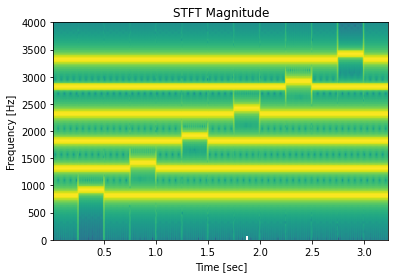

In [97]:
demo1_alg = "U U' D D' R R' L L' F F' B B'"
demo1_wav_path = "demo1_all_turns.wav"
render_audible_alg(demo1_alg, demo1_wav_path)
visualize(demo1_wav_path)

### Demo 2: Sweep through every possible state frequency.

c:\Users\Joseph Hale\git\DIY-Supercube\venv\lib\site-packages\matplotlib\axes\_axes.py:7723: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


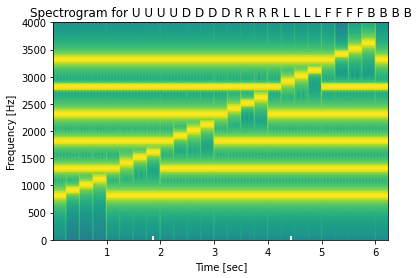

In [102]:
demo2_alg = "U U U U D D D D R R R R L L L L F F F F B B B B"
demo2_wav_path = 'demo2_all_states.wav'
render_audible_alg(demo2_alg, demo2_wav_path)
visualize(demo2_wav_path)

### Demo 3: The "Trigger" Algorithm
This 4-move sequence is the algorithm used most frequently over the course of a Rubik's Cube solve.

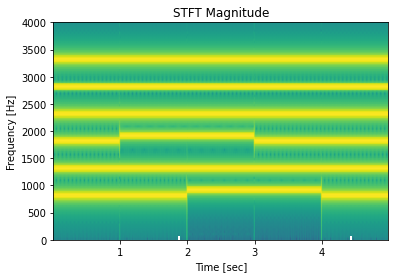

In [99]:
demo3_alg = "R U R' U'"
demo3_wav_path = 'demo3_trigger.wav'
render_audible_alg(demo3_alg, demo3_wav_path, tps=1)
visualize(demo3_wav_path)

### Optional: Audio playback
Run one of the following cells to hear the synthesized audio.
(Note there is a bug with `playsound` that will only allow you to run either of the cells once, after which an error occurs).

In [57]:
# Demo 1: Listen to the generated audio
# from playsound import playsound
# playsound('demo1_all_turns.wav')

In [58]:
# Demo 2: Listen to the generated audio
# from playsound import playsound
# playsound('demo2_all_states.wav')

In [59]:
# Demo 3: Listen to the generated audio
# from playsound import playsound
# playsound('demo3_trigger.wav')

# Parsing a Rubik's Cube Algorithm from Audio
The first major challenge in building this DIY Supercube is architecting an algorithm that can decode the move sequence applied to a Rubik's cube from just an audio recording of its emitted tones.

## Examining the Waveform
Let's start by taking a look at the actual waveform of the audio we generated in Demo 2.

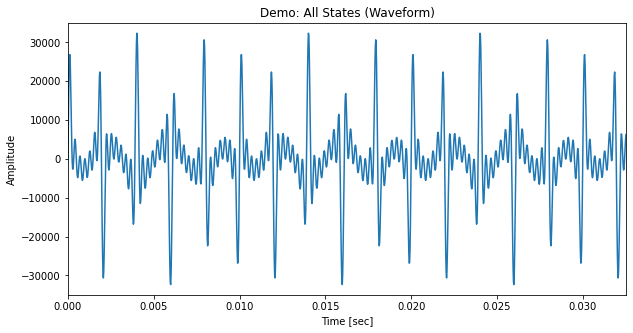

In [116]:
import matplotlib.pyplot as plt
from scipy.io import wavfile

sample_rate, audio_samples = wavfile.read(demo2_wav_path)
time = [ i / sample_rate for i in range(len(audio_samples)) ]  # Convert to seconds.
samples_per_move = len(audio_samples) // len(demo2_alg.split(" "))

plt.plot(time[:samples_per_move // 8], audio_samples[:samples_per_move // 8])
plt.axis([0, max(time[:samples_per_move // 8]), -35000, 35000])
plt.title('Demo: All States (Waveform)')
plt.ylabel('Amplitude')
plt.xlabel('Time [sec]')
plt.rcParams["figure.figsize"] = (10,5)


Looking at the graph we clearly see five distinct sections of the waveform, one for the initial state of the cube, and an additional section for the state after each of the four moves in the trigger algorithm.

If you look closely, you'll notice that the first and the last section look exactly the same, which matches the spectrogram we generated for the trigger move.

The question now is, "How do we programmatically reconstruct the trigger algorithm from just this audio?"

### Detecting the Frequencies Present in an Audio Sample
If we had the specific audio frequencies present in the waveform at any given point in time, we could compare them with the Frequency Assignments we gave to each face position to determine the cube's state at that moment in time.

To make the conversion from the raw wave form to the specific audio frequencies that compose it we can use a Fourier Transform.

In [78]:
# Heavily aided by https://matplotlib.org/stable/gallery/animation/simple_anim.html#sphx-glr-gallery-animation-simple-anim-py
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from scipy import signal
from scipy.io import wavfile

def animate(wav_path: str, alg: str):
    # Parse the audio sample into its spectrogram
    SAMPLES_PER_WINDOW = 1024  # Seems to balance frequency precision with time precision.
    sample_rate, audio_samples = wavfile.read(wav_path)
    freq, time, Zxx = signal.stft(audio_samples, fs=sample_rate,
        nperseg=SAMPLES_PER_WINDOW, noverlap=(SAMPLES_PER_WINDOW // 4) * 3)
    spectrogram = np.abs(Zxx).transpose()

    # Generate the plots
    fig, (ax_spectrogram, ax_fourier) = plt.subplots(2)

    # Set the spectrogram
    ax_spectrogram.specgram(audio_samples,
        Fs=sample_rate, 
        NFFT=SAMPLES_PER_WINDOW, 
        noverlap=SAMPLES_PER_WINDOW // 4 * 3)  # 3/4 of the window size
    line_spectrogram, = ax_spectrogram.plot([], [], '-', color='red')
    time_tracker_spectrogram = ax_spectrogram.axvline(0, color='red')
    ax_spectrogram.set_ylim(0, 4000)
    ax_spectrogram.set_title(f"Spectrogram")
    ax_spectrogram.set_ylabel('Frequency [Hz]')
    ax_spectrogram.set_xlabel('Time [sec]')

    # Set the Fourier transform
    STEP = 10
    indices = np.arange(0, len(time) + 1, step=STEP)
    line_fourier, = ax_fourier.plot(freq, spectrogram[0], color='red')
    ax_fourier.set_title("")
    ax_fourier.set_xlim(0, 4000)  # Frequency
    ax_fourier.set_xlabel("Frequency [Hz]")
    ax_fourier.set_ylim(0, np.amax(spectrogram))  # Strength
    ax_fourier.set_ylabel("Strength")

    # Space figures nicely
    fig.suptitle(alg)
    fig.tight_layout(h_pad=3)

    def draw_frame_at(i):
        time_tracker_spectrogram.set_xdata(time[i])
        line_fourier.set_ydata(spectrogram[i])
        ax_fourier.set_title(f"Frequencies at {time[i]:.2f} seconds")
        return line_spectrogram, line_fourier

    ani = animation.FuncAnimation(fig, draw_frame_at,
        frames=indices, interval=1, blit=True, save_count=len(time)/STEP)
    ani.save(f"plt/animation/{wav_path[:-4]}.mp4",
        fps=len(time)/STEP/5, dpi=300)
    plt.show()


c:\Users\Joseph Hale\git\DIY-Supercube\venv\lib\site-packages\matplotlib\axes\_axes.py:7723: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


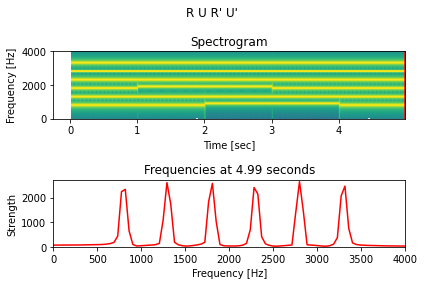

In [80]:
animate(demo3_wav_path, demo3_alg)

c:\Users\Joseph Hale\git\DIY-Supercube\venv\lib\site-packages\matplotlib\axes\_axes.py:7723: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


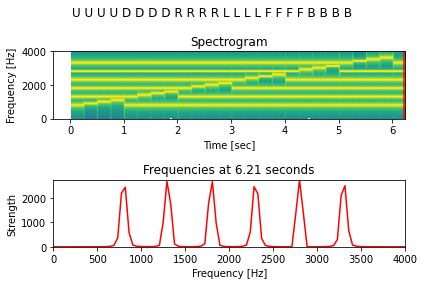

In [81]:
animate(demo2_wav_path, demo2_alg)

# Appendix
Other blocks of code/commentary to keep for reference.

In [ ]:
def assert_move_validity(self, move: str):
    assert (0 < len(move) <= 2 and move[0] in self.state.keys() 
            and move[1] == "'" if len(move) == 2 else True), \
        f"The given move ({move}), must start with " \
        f"a valid face [one of {self.state.keys()}] and optionally " \
        "carry a single apostrophe [']"